In [23]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [82]:
def predict_tflite(interpreter, x_test):

  # Initialize the TFLite interpreter
  # interpreter = tf.lite.Interpreter(model_content=tflite_model)
  # interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test = x_test / input_scale + input_zero_point
    x_test = x_test.astype(input_details["dtype"])
  
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], x_test)
  interpreter.invoke()
  y_pred = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = tf.keras.losses.get(model.loss)
  loss = loss_function(y_true, y_pred).numpy()
  return loss


In [80]:
f_model = "Models/_Lite/"
# Load the TFLite model and allocate tensors.
model = tf.lite.Interpreter(model_path=f_model+"WaveNetFinal0.4.tflite")
model.allocate_tensors()
modelq = tf.lite.Interpreter(model_path=f_model+"WaveNetFinal0.4quantized.tflite")
modelq.allocate_tensors()

# # Get input and output tensors.
# input_details = model.get_input_details()
# output_details = model.get_output_details()


In [73]:
with open("PrepedData/Test/LPG4XTest0.4.npy", "rb") as f:
    XTest = np.load(f)
with open("PrepedData/Test/LPG4YTest0.4.npy", "rb") as f:
    YTest = np.load(f)

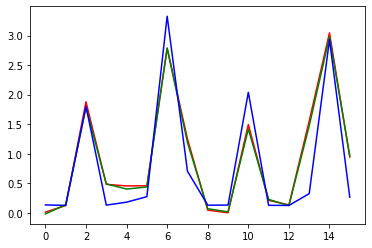

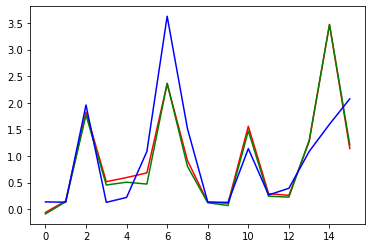

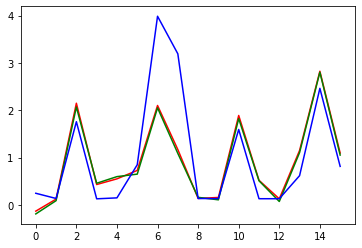

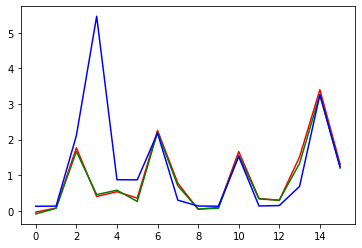

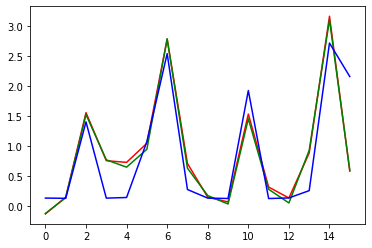

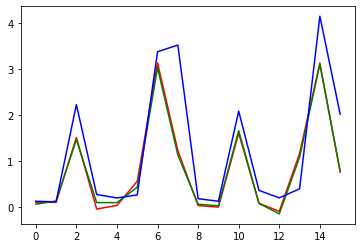

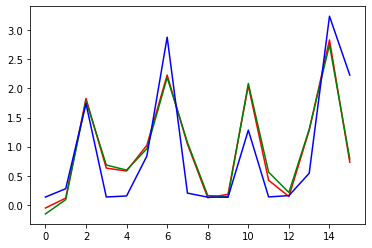

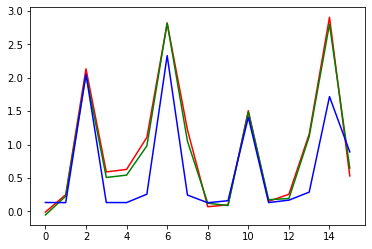

<Figure size 432x288 with 0 Axes>

In [83]:
for i in range(min(len(XTest),8)):
    output_data = predict_tflite(model,XTest[i:i+1])
    output_dataq = predict_tflite(modelq,XTest[i:i+1])
    # model.set_tensor(input_details[0]['index'], XTest[i:i+1])
    # model.invoke()
    # output_data = model.get_tensor(output_details[0]['index'])

    plt.plot(output_data.flatten(),'r')
    plt.plot(output_dataq.flatten(),'g')
    plt.plot(YTest[i],'b')
    plt.figure()

In [48]:
output_data = np.zeros((1,40,16))
for i in range(40):
    model.set_tensor(input_details[0]['index'], XTest[0:1,i:i+1,:])
    model.invoke()
    output_data[0,i,:] = model.get_tensor(output_details[0]['index'])

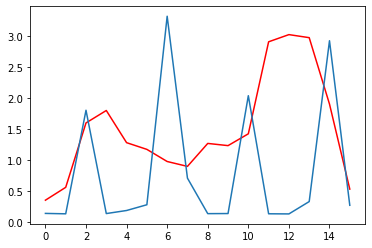

In [50]:
i = 39
plt.plot(output_data[0,i],'r')
plt.plot(YTest[0,i])

In [3]:
class TestModel(tf.Module):
  def __init__(self):
    super(TestModel, self).__init__()

  @tf.function(input_signature=[tf.TensorSpec(shape=[1, 10], dtype=tf.float32)])
  def add(self, x):
    '''
    Simple method that accepts single input 'x' and returns 'x' + 4.
    '''
    # Name the output 'result' for convenience.
    return {'result' : x + 4}


SAVED_MODEL_PATH = 'content/saved_models/test_variable'
TFLITE_FILE_PATH = 'content/test_variable.tflite'

# Save the model
module = TestModel()
# You can omit the signatures argument and a default signature name will be
# created with name 'serving_default'.
tf.saved_model.save(
    module, SAVED_MODEL_PATH,
    signatures={'my_signature':module.add.get_concrete_function()})

# Convert the model using TFLiteConverter
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
tflite_model = converter.convert()
with open(TFLITE_FILE_PATH, 'wb') as f:
  f.write(tflite_model)

# Load the TFLite model in TFLite Interpreter
interpreter = tf.lite.Interpreter(TFLITE_FILE_PATH)
# There is only 1 signature defined in the model,
# so it will return it by default.
# If there are multiple signatures then we can pass the name.
my_signature = interpreter.get_signature_runner()

# my_signature is callable with input as arguments.
output = my_signature(x=tf.constant([1.0], shape=(1,10), dtype=tf.float32))
# 'output' is dictionary with all outputs from the inference.
# In this case we have single output 'result'.
print(output['result'])

INFO:tensorflow:Assets written to: content/saved_models/test_variable\assets
[[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]]
